# Customer Segmentation using K-Means Clustering

In [8]:

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import numpy as np

def davies_bouldin_score(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_k = [X[labels == k] for k in range(n_clusters)]
    centroids = [np.mean(cluster, axis=0) for cluster in cluster_k]
    cluster_dists = [np.mean(pairwise_distances(cluster, [centroid])) for cluster, centroid in zip(cluster_k, centroids)]
    
    scores = []
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                score = (cluster_dists[i] + cluster_dists[j]) / np.linalg.norm(centroids[i] - centroids[j])
                scores.append(score)
    
    return np.mean(scores)

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Step 1: Aggregate transaction data to compute customer-level metrics
customer_transactions = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TotalTransactions=('TransactionID', 'count'),
    AverageTransactionValue=('TotalValue', 'mean')
).reset_index()

# Step 2: Merge aggregated data with customer profile information
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Handle missing values
customer_data[['TotalSpend', 'TotalTransactions', 'AverageTransactionValue']] = customer_data[
    ['TotalSpend', 'TotalTransactions', 'AverageTransactionValue']
].fillna(0)



# Convert string categories to numeric labels
label_encoder = LabelEncoder()
customer_data['Region_Encoded'] = label_encoder.fit_transform(customer_data['Region'])

# One-hot encode the numeric labels
encoder = OneHotEncoder(sparse=False)
region_encoded = encoder.fit_transform(customer_data[['Region_Encoded']])

# Generate column names manually
region_column_names = [f"Region_{category}" for category in label_encoder.classes_]
region_encoded_df = pd.DataFrame(region_encoded, columns=region_column_names)

# Combine the one-hot encoded data with the original DataFrame
customer_data = pd.concat([customer_data, region_encoded_df], axis=1)



# Normalize numeric columns
scaler = MinMaxScaler()
numeric_columns = ['TotalSpend', 'TotalTransactions', 'AverageTransactionValue']
customer_data[numeric_columns] = scaler.fit_transform(customer_data[numeric_columns])

# Drop unnecessary columns for clustering
processed_customer_data = customer_data.drop(columns=['CustomerID', 'CustomerName', 'Region', 'SignupDate'])


## Finding the Optimal Number of Clusters

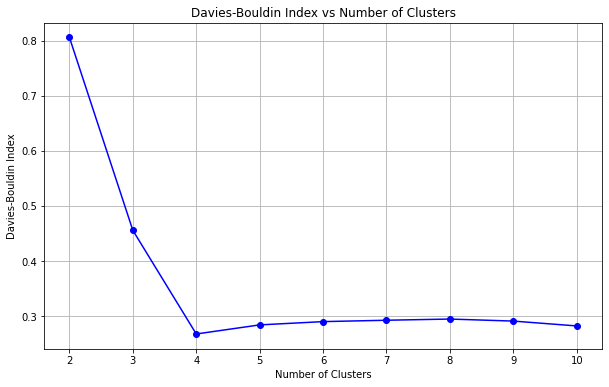

Optimal Number of Clusters: 4
Best Davies-Bouldin Index: 0.2674060655479285


In [9]:

# Perform K-Means clustering for different cluster sizes (2 to 10)
db_scores = []
cluster_range = range(2, 11)
best_model = None
best_db_score = float('inf')
best_n_clusters = None

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(processed_customer_data)
    db_score = davies_bouldin_score(processed_customer_data, labels)
    db_scores.append(db_score)

    if db_score < best_db_score:
        best_db_score = db_score
        best_model = kmeans
        best_n_clusters = n_clusters

# Visualize Davies-Bouldin Index across different cluster sizes
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_scores, marker='o', linestyle='-', color='b')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(cluster_range)
plt.grid()
plt.show()

# Best clustering results
best_labels = best_model.labels_
print("Optimal Number of Clusters:", best_n_clusters)
print("Best Davies-Bouldin Index:", best_db_score)


## Visualizing the Clusters

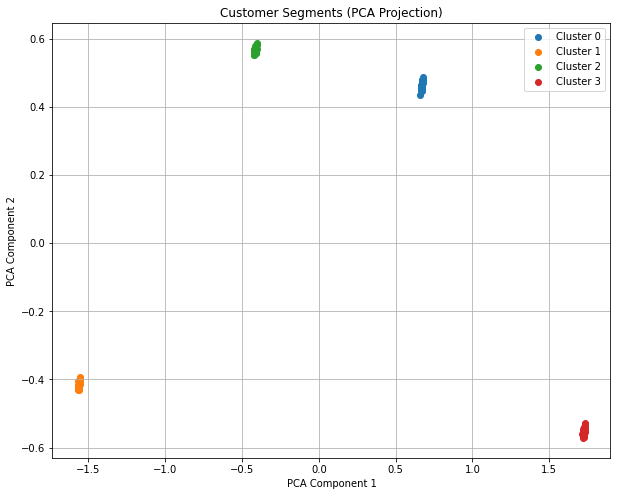

In [10]:

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_customer_data)
visualization_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
visualization_df['Cluster'] = best_labels

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in range(best_n_clusters):
    cluster_data = visualization_df[visualization_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


## Analyzing Cluster Characteristics

In [11]:

# Analyze cluster characteristics
cluster_analysis = processed_customer_data.copy()
cluster_analysis['Cluster'] = best_labels
cluster_summary = cluster_analysis.groupby('Cluster').mean()

print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
         TotalSpend  TotalTransactions  AverageTransactionValue  \
Cluster                                                           
0          0.311517           0.425455                 0.526252   
1          0.348312           0.468413                 0.529552   
2          0.310212           0.482213                 0.483668   
3          0.316609           0.440404                 0.524613   

         Region_Encoded  Region_Asia  Region_Europe  Region_North America  \
Cluster                                                                     
0                     1          0.0            1.0                   0.0   
1                     3          0.0            0.0                   0.0   
2                     2          0.0            0.0                   1.0   
3                     0          1.0            0.0                   0.0   

         Region_South America  
Cluster                        
0                         0.0  
1                    